<a href="https://colab.research.google.com/github/DanishFaraaz/Deep-Learning-Projects/blob/main/27_Keras_Neural_Style_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import tensorflow as tf

# Load compressed model from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

In [2]:
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

In [3]:
def tensor_to_image(tensor):
  tensor = tensor * 255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

In [4]:
content_path = tf.keras.utils.get_file('labrador.jpeg', 'https://github.com/rajeevratan84/ModernComputerVision/raw/main/labrador.jpeg')
style_path = tf.keras.utils.get_file('the_wave.jpeg', 'https://github.com/rajeevratan84/ModernComputerVision/raw/main/the_wave.jpg')

148634/148634 [==============================] - 0s 0us/step


**Function to load image and limit maximum dimenstion to 512 pixels**

In [5]:
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]

  return img

In [6]:
def imshow(img, title=None):
  if len(img.shape)>1:
    image = tf.squeeze(img, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

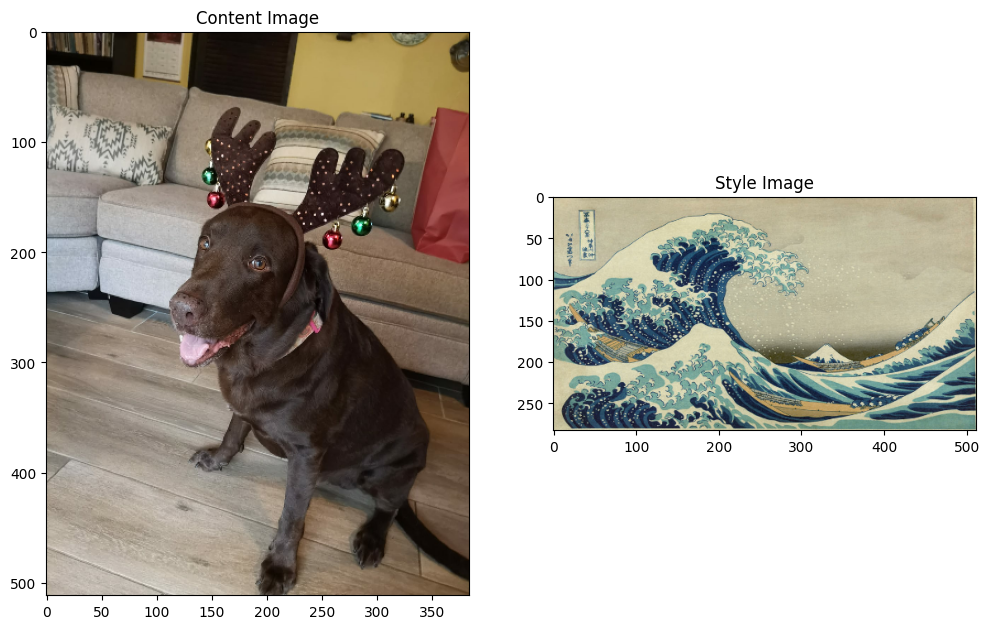

In [8]:
content_img = load_img(content_path)
style_img = load_img(style_path)

plt.subplot(1,2,1)
imshow(content_img, 'Content Image')

plt.subplot(1,2,2)
imshow(style_img, 'Style Image')

**Fast Style Transform using TF-Hub**

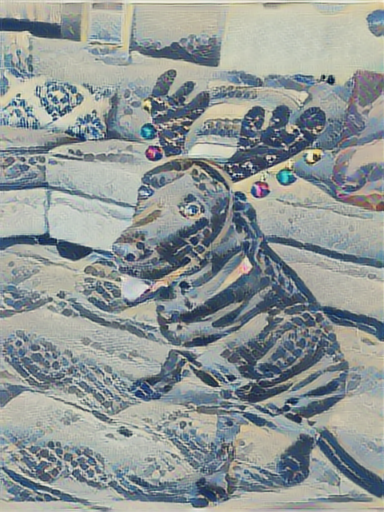

In [10]:
import tensorflow_hub as hub

hub_model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')

stylized_image = hub_model(tf.constant(content_img), tf.constant(style_img))[0]

tensor_to_image(stylized_image)

**Implementing Model from Scratch**

In [14]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

for layer in vgg.layers:
  print(layer.name)

80134624/80134624 [==============================] - 4s 0us/step
input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [15]:
content_layers = ['block5_conv2']

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

**Build the Model**

In [18]:
def vgg_layers(layer_name):
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False

  outputs = [vgg.get_layer(name).output for name in layer_name]

  model = tf.keras.Model([vgg.input], outputs)
  return model

In [19]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_img*255)

for name, output in zip(style_layers, style_outputs):
  print(name)
  print('shape: ',output.numpy().shape)
  print('min: ',output.numpy().min())
  print('max: ',output.numpy().max())
  print('mean: ',output.numpy().mean())
  print()

block1_conv1
shape:  (1, 283, 512, 64)
min:  0.0
max:  723.07404
mean:  31.025566

block2_conv1
shape:  (1, 141, 256, 128)
min:  0.0
max:  3439.768
mean:  182.62827

block3_conv1
shape:  (1, 70, 128, 256)
min:  0.0
max:  9064.3
mean:  167.78822

block4_conv1
shape:  (1, 35, 64, 512)
min:  0.0
max:  17980.34
mean:  670.36206

block5_conv1
shape:  (1, 17, 32, 512)
min:  0.0
max:  2495.8228
mean:  51.209606



**Calculate Style**

In [20]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result / (num_locations)

**Extract Style and Content**

In [21]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg = vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    'Expects float input in [0,1]'
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers], outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output) for style_output in style_outputs]

    content_dict = {content_name: value for content_name, value in zip(self.content_layers, content_outputs)}
    style_dict = {style_name: value for style_name, value in zip(self.style_layers, style_outputs)}

    return {'content': content_dict, 'style': style_dict}

In [22]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_img))

print('Style:')
for name, output in sorted(results['style'].items()):
  print(name)
  print('shape: ',output.numpy().shape)
  print('min: ',output.numpy().min())
  print('max: ',output.numpy().max())
  print('mean: ',output.numpy().mean())
  print()

print('Content:')
for name, output in sorted(results['content'].items()):
  print(name)
  print('shape: ',output.numpy().shape)
  print('min: ',output.numpy().min())
  print('max: ',output.numpy().max())
  print('mean: ',output.numpy().mean())
  print()

Style:
block1_conv1
shape:  (1, 64, 64)
min:  0.06304491
max:  13911.914
mean:  296.93304

block2_conv1
shape:  (1, 128, 128)
min:  0.0
max:  64059.83
mean:  10343.316

block3_conv1
shape:  (1, 256, 256)
min:  0.0
max:  185306.11
mean:  10553.732

block4_conv1
shape:  (1, 512, 512)
min:  4.8409886
max:  2194159.0
mean:  180767.27

block5_conv1
shape:  (1, 512, 512)
min:  0.0
max:  91869.75
mean:  2065.271

Content:
block5_conv2
shape:  (1, 32, 24, 512)
min:  0.0
max:  1515.428
mean:  17.741594



**Running the Gradient Descent**

In [23]:
style_targets = extractor(style_img)['style']
content_targets = extractor(content_img)['content']

In [24]:
image = tf.Variable(content_img)

In [25]:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [26]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

In [28]:
style_weight = 1e-2
content_weight = 1e4

In [29]:
def style_content_loss(outputs):
  style_outputs = outputs['style']
  content_outputs = outputs['content']

  style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) for name in style_outputs.keys()])
  style_loss *= style_weight / num_style_layers

  content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) for name in content_outputs.keys()])
  content_loss *= content_weight / num_content_layers

  loss = style_loss + content_loss
  return loss

In [31]:
@tf.function()

def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

**Run a few steps to test**

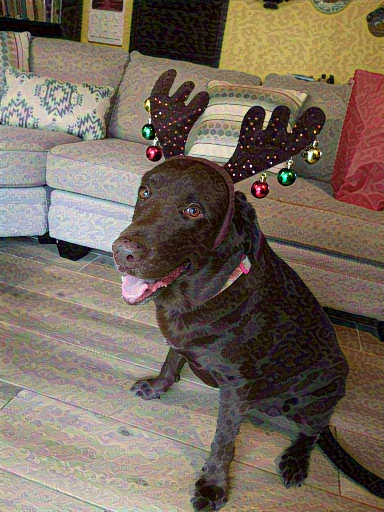

In [32]:
train_step(image)
train_step(image)
train_step(image)
tensor_to_image(image)

**Perform longer optimization**

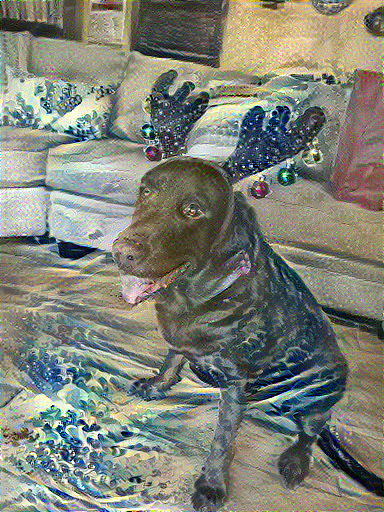

Train step: 1000
Total Time: 71.5


In [34]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print('.', end='')
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print('Train step: {}'.format(step))

end = time.time()
print('Total Time: {:.1f}'.format(end-start))